# Titanic - Machine Learning from Disaster

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import xgboost as xgb

import os

from re import search

from pprint import pprint

import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Global variables
SEED = 42
suptitle_param = dict(color='darkblue', fontsize=20)
title_param = {'color': 'darkred', 'fontsize': 16}
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

In [3]:
# Global configuration
np.random.seed(SEED)
plt.rcParams.update({'axes.labelsize': 10, 'xtick.labelsize': 10, 'ytick.labelsize': 10, 
                     'legend.fontsize': 10, 'font.size': 10})

## 1. First Step - Read the data

In [4]:
# Read titanic data
df = pd.read_csv('train.csv', index_col='PassengerId')

In [5]:
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [7]:
df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## 2. EDA - Exploration Data Analysis

In [8]:
# Amount of Survived
survived = df.groupby(['Pclass', 'Survived']).Survived.count()
print(survived)
print(survived.groupby(level=[0]).apply(lambda g: g / g.sum()))

df.groupby('Survived').Survived.count()/df.shape[0]

Pclass  Survived
1       0            80
        1           136
2       0            97
        1            87
3       0           372
        1           119
Name: Survived, dtype: int64
Pclass  Survived
1       0           0.370370
        1           0.629630
2       0           0.527174
        1           0.472826
3       0           0.757637
        1           0.242363
Name: Survived, dtype: float64


Survived
0    0.616162
1    0.383838
Name: Survived, dtype: float64

In [9]:
# Looking for Fare less than $15
df[(df.Fare<15) & (df.Survived==1)]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C
22,1,2,"Beesley, Mr. Lawrence",male,34.0,0,0,248698,13.0000,D56,S
...,...,...,...,...,...,...,...,...,...,...,...
856,1,3,"Aks, Mrs. Sam (Leah Rosen)",female,18.0,0,1,392091,9.3500,NaN,S
866,1,2,"Bystrom, Mrs. (Karolina)",female,42.0,0,0,236852,13.0000,NaN,S
867,1,2,"Duran y More, Miss. Asuncion",female,27.0,1,0,SC/PARIS 2149,13.8583,NaN,C


In [10]:
# Checking the free Fare
print('Minimun value (greater than $0.00  ): $', df[df.Fare>0].Fare.min())
print('Minimun value (greater than $4.0125): $', df[df.Fare>4.0125].Fare.min())
print(df.groupby('Fare').Fare.count())
df[(df.Fare<7) & (df.Age.isnull())]

Minimun value (greater than $0.00  ): $ 4.0125
Minimun value (greater than $4.0125): $ 5.0
Fare
0.0000      15
4.0125       1
5.0000       1
6.2375       1
6.4375       1
            ..
227.5250     4
247.5208     2
262.3750     2
263.0000     4
512.3292     3
Name: Fare, Length: 248, dtype: int64


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
278,0,2,"Parkes, Mr. Francis ""Frank""",male,NaN,0,0,239853,0.0000,NaN,S
412,0,3,"Hart, Mr. Henry",male,NaN,0,0,394140,6.8583,NaN,Q
414,0,2,"Cunningham, Mr. Alfred Fleming",male,NaN,0,0,239853,0.0000,NaN,S
467,0,2,"Campbell, Mr. William",male,NaN,0,0,239853,0.0000,NaN,S
482,0,2,"Frost, Mr. Anthony Wood ""Archie""",male,NaN,0,0,239854,0.0000,NaN,S
634,0,1,"Parr, Mr. William Henry Marsh",male,NaN,0,0,112052,0.0000,NaN,S
675,0,2,"Watson, Mr. Ennis Hastings",male,NaN,0,0,239856,0.0000,NaN,S
733,0,2,"Knight, Mr. Robert J",male,NaN,0,0,239855,0.0000,NaN,S
816,0,1,"Fry, Mr. Richard",male,NaN,0,0,112058,0.0000,B102,S


In [11]:
# Looking for null values
df.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [12]:
# Exploring null Embarked data
df[df.Embarked.isnull()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [13]:
# Exploring null Age data
df[df.Age.isnull()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C
27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C
29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q
...,...,...,...,...,...,...,...,...,...,...,...
860,0,3,"Razi, Mr. Raihed",male,NaN,0,0,2629,7.2292,NaN,C
864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.5500,NaN,S
869,0,3,"van Melkebeke, Mr. Philemon",male,NaN,0,0,345777,9.5000,NaN,S


In [14]:
# Exploring the mean age per group
df.groupby(['Pclass', 'Sex', 'Embarked']).Age.mean()

Pclass  Sex     Embarked
1       female  C           36.052632
                Q           33.000000
                S           32.704545
        male    C           40.111111
                Q           44.000000
                S           41.897188
2       female  C           19.142857
                Q           30.000000
                S           29.719697
        male    C           25.937500
                Q           57.000000
                S           30.875889
3       female  C           14.062500
                Q           22.850000
                S           23.223684
        male    C           25.016800
                Q           28.142857
                S           26.574766
Name: Age, dtype: float64

## 3. Clean Data

In [15]:
# Dealing with Embarked data
#df.drop(df.groupby('Sex').Sex.count(), inplace=True)
df['Embarked'].fillna('Unknown', inplace=True)
print('Null values in Embarked:', df.Embarked.isnull().sum())

Null values in Embarked: 0


In [16]:
# Fill null values in Age mean
df['Age'].fillna(df.groupby(['Pclass', 'Sex', 'Embarked']).Age.transform('mean'), inplace=True)
print(df.isnull().sum())

Survived      0
Pclass        0
Name          0
Sex           0
Age           0
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      0
dtype: int64


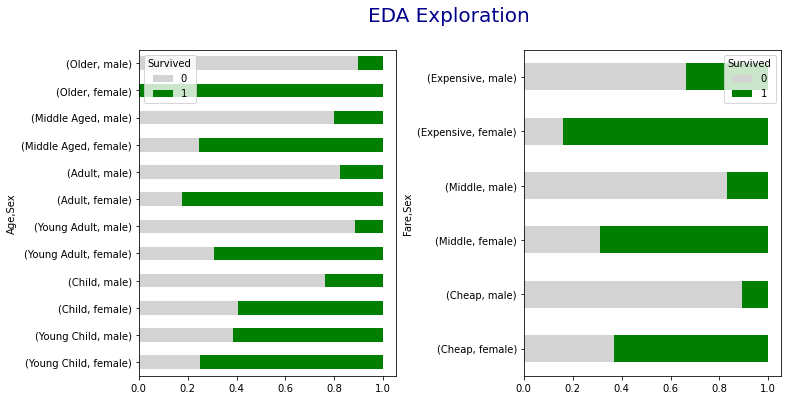

In [17]:
bins = [0, 7, 16, 25, 40, 60, 100]
binNames =['Young Child', 'Child', 'Young Adult', 'Adult', 'Middle Aged', 'Older']
binAge = pd.cut(df.Age, bins, labels=binNames)

binFare = pd.qcut(df.Fare, 3, labels=['Cheap', 'Middle', 'Expensive'])

fig, axes = plt.subplots(1,2, figsize=(11.5, 6))
binVars = [binAge, binFare]
for i in range(2):
    group = df.groupby([binVars[i], 'Sex', 'Survived'])
    group = group.size().unstack()
    group = group.div(group.sum(axis=1), axis=0)
    ax = group.plot(kind='barh', stacked=True, color=['lightgray', 'green'], ax=axes[i])

plt.subplots_adjust(left=None, right=None, bottom=None, top=None, hspace=None, wspace=.5);
fig.suptitle('EDA Exploration', **suptitle_param)
plt.show()

In [18]:
# Clarifing size() and unstack()
#group = df.groupby([binVars[0], 'Sex', 'Survived'])
#print(group.size())
#group.size().unstack()

## 4. Feature Engineering

In [19]:
# Extracting title from Name
def defining_title(name, sex):
    """Define the title associate to the person's name."""
    if search('Countess|Mme|Mrs', name): return 'Mrs'
    elif search('Mlle|Ms|Miss', name): return 'Miss'
    elif search('Don|Major|Capt|Jonkheer|Rev|Col|Mr|Master', name): return 'Mr'
    elif search('Dr', name):
        if sex == 'male': return 'Mr'
        else: return 'Mrs'
    else: return 'No title'
df['Title'] = df.apply(lambda data: defining_title(data['Name'], data['Sex']), axis=1)
print(df.groupby('Title').Title.count())
df.groupby('Sex').Sex.count()

Title
Miss    182
Mr      577
Mrs     132
Name: Title, dtype: int64


Sex
female    314
male      577
Name: Sex, dtype: int64

In [20]:
#Turning cabin number into Deck
def contain_a_string(text, list_to_find):
    """Find a string inside a given text."""
    string_to_find = '|'.join(list_to_find)
    m = search(string_to_find, text)
    if m:
        return text[m.start():m.end()]
    return 'Unkonwn'

cabin_list = ['A', 'B', 'C', 'D', 'E', 'F', 'T', 'G', 'Unknown']

df['Deck'] = df['Cabin'].fillna('').apply(lambda cab: contain_a_string(cab, cabin_list))
print(df.groupby(['Pclass', 'Deck']).Deck.count())
df[df.Deck.isin(['T', 'G'])]

Pclass  Deck   
1       A           15
        B           47
        C           59
        D           29
        E           25
        T            1
        Unkonwn     40
2       D            4
        E            4
        F            8
        Unkonwn    168
3       E            3
        F            5
        G            4
        Unkonwn    479
Name: Deck, dtype: int64


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Deck
PassengerId,,,,,,,,,,,,,
11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S,Miss,G
206,0,3,"Strom, Miss. Telma Matilda",female,2.0,0,1,347054,10.4625,G6,S,Miss,G
252,0,3,"Strom, Mrs. Wilhelm (Elna Matilda Persson)",female,29.0,1,1,347054,10.4625,G6,S,Mrs,G
340,0,1,"Blackwell, Mr. Stephen Weart",male,45.0,0,0,113784,35.5000,T,S,Mr,T
395,1,3,"Sandstrom, Mrs. Hjalmar (Agnes Charlotta Bengt...",female,24.0,0,2,PP 9549,16.7000,G6,S,Mrs,G


In [21]:
#Creating new family_size column
df['FamilySize'] = df['SibSp'] + df['Parch']
print(df.groupby('FamilySize').FamilySize.count())
df[(df.FamilySize > 4) & (df.Survived==1)]

FamilySize
0     537
1     161
2     102
3      29
4      15
5      22
6      12
7       6
10      7
Name: FamilySize, dtype: int64


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Deck,FamilySize
PassengerId,,,,,,,,,,,,,,
26,1,3,"Asplund, Mrs. Carl Oscar (Selma Augusta Emilia...",female,38.0,1,5,347077,31.3875,NaN,S,Mrs,Unkonwn,6
69,1,3,"Andersson, Miss. Erna Alexandra",female,17.0,4,2,3101281,7.9250,NaN,S,Miss,Unkonwn,6
89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.0000,C23 C25 C27,S,Miss,C,5
234,1,3,"Asplund, Miss. Lillian Gertrud",female,5.0,4,2,347077,31.3875,NaN,S,Miss,Unkonwn,6
262,1,3,"Asplund, Master. Edvin Rojj Felix",male,3.0,4,2,347077,31.3875,NaN,S,Mr,Unkonwn,6
342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.0000,C23 C25 C27,S,Miss,C,5
438,1,2,"Richards, Mrs. Sidney (Emily Hocking)",female,24.0,2,3,29106,18.7500,NaN,S,Mrs,Unkonwn,5


In [22]:
# Getting only the data required
df.drop(['Name', 'Ticket', 'Cabin'], axis=1, inplace=True)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    int64  
 1   Pclass      891 non-null    int64  
 2   Sex         891 non-null    object 
 3   Age         891 non-null    float64
 4   SibSp       891 non-null    int64  
 5   Parch       891 non-null    int64  
 6   Fare        891 non-null    float64
 7   Embarked    891 non-null    object 
 8   Title       891 non-null    object 
 9   Deck        891 non-null    object 
 10  FamilySize  891 non-null    int64  
dtypes: float64(2), int64(5), object(4)
memory usage: 83.5+ KB
None


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Deck,FamilySize
PassengerId,,,,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S,Mr,Unkonwn,1
2,1,1,female,38.0,1,0,71.2833,C,Mrs,C,1
3,1,3,female,26.0,0,0,7.9250,S,Miss,Unkonwn,0
4,1,1,female,35.0,1,0,53.1000,S,Mrs,C,1
5,0,3,male,35.0,0,0,8.0500,S,Mr,Unkonwn,0


## 5. One Hot Encoding

In [23]:
#df['Survived'] = df['Survived'].astype('category')
#df['phone'] = df['phone'].astype('category')
#df = pd.get_dummies(df)

# Create OneHotEncoder: ohe
ohe = ColumnTransformer([("Pclass", OneHotEncoder(drop='first'), ['Pclass']),
                         ("Sex", OneHotEncoder(drop='first'), ['Sex']),
                         ("Embarked", OneHotEncoder(drop='first'), ['Embarked']),
                         ("Title", OneHotEncoder(drop='first'), ['Title']),
                         ("Deck", OneHotEncoder(drop='first'), ['Deck'])], 
                        remainder = 'passthrough',
                        sparse_threshold = 0,
                        verbose = True)

# Apply OneHotEncoder to categorical columns - output is no longer a dataframe: data_encoded
data_encoded = ohe.fit_transform(df)

# Print the shape of the original DataFrame and the transformed array
print("Before OneHotEncoder:", df.shape)
print("After OneHotEncoder:", data_encoded.shape)

# Transforming to df
df_data = pd.DataFrame(data=data_encoded, columns=ohe.get_feature_names())
df_data.head()

[ColumnTransformer] ........ (1 of 6) Processing Pclass, total=   0.0s
[ColumnTransformer] ........... (2 of 6) Processing Sex, total=   0.0s
[ColumnTransformer] ...... (3 of 6) Processing Embarked, total=   0.0s
[ColumnTransformer] ......... (4 of 6) Processing Title, total=   0.0s
[ColumnTransformer] .......... (5 of 6) Processing Deck, total=   0.0s
[ColumnTransformer] ..... (6 of 6) Processing remainder, total=   0.0s
Before OneHotEncoder: (891, 11)
After OneHotEncoder: (891, 22)


,Pclass__x0_2,Pclass__x0_3,Sex__x0_male,Embarked__x0_Q,Embarked__x0_S,Embarked__x0_Unknown,Title__x0_Mr,Title__x0_Mrs,Deck__x0_B,Deck__x0_C,...,Deck__x0_F,Deck__x0_G,Deck__x0_T,Deck__x0_Unkonwn,Survived,Age,SibSp,Parch,Fare,FamilySize
0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,22.0,1.0,0.0,7.2500,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,38.0,1.0,0.0,71.2833,1.0
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,26.0,0.0,0.0,7.9250,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,35.0,1.0,0.0,53.1000,1.0
4,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,35.0,0.0,0.0,8.0500,0.0


## 6. Alternative with MinMaxScaler

In [24]:
scaler = MinMaxScaler()

df_data = pd.DataFrame(data = scaler.fit_transform(df_data), columns = df_data.columns)
df_data.head()

,Pclass__x0_2,Pclass__x0_3,Sex__x0_male,Embarked__x0_Q,Embarked__x0_S,Embarked__x0_Unknown,Title__x0_Mr,Title__x0_Mrs,Deck__x0_B,Deck__x0_C,...,Deck__x0_F,Deck__x0_G,Deck__x0_T,Deck__x0_Unkonwn,Survived,Age,SibSp,Parch,Fare,FamilySize
0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.271174,0.125,0.0,0.014151,0.1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.472229,0.125,0.0,0.139136,0.1
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.321438,0.000,0.0,0.015469,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.434531,0.125,0.0,0.103644,0.1
4,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.434531,0.000,0.0,0.015713,0.0


## 6. First model approach: XGBoost

In [25]:
# Create arrays for the features and the target: X, y
X, y = df_data.drop('Survived', axis=1), df_data.Survived
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

# define the datasets to evaluate each iteration
evalset = [(X_train, y_train), (X_test,y_test)]

# Setup the pipeline steps: steps
xg_cl = xgb.XGBClassifier(objective='binary:logistic', #colsample_bytree=1, --> default value
                          n_estimators=10, use_label_encoder=False, eval_metric='error', 
                          max_depth=3, seed=SEED)
# Perform cross-validation
cross_val_scores = cross_val_score(xg_cl, X_train, y_train, cv=3, scoring='roc_auc')

# Print avg. AUC
print("3-fold AUC (on the training set): ", np.mean(cross_val_scores))

# Fit the classifier to the training set
metrics = ['auc', 'logloss']
xg_cl.fit(X_train, y_train, eval_metric=metrics, eval_set=evalset, verbose=0)

# Predict the labels of the test set: preds
preds = xg_cl.predict(X_test)

# evaluate performance - Compute the accuracy: accuracy
score = accuracy_score(y_test, preds)
print('3-fold AUC (on the test     set): ', score)

3-fold AUC (on the training set):  0.8609636321714973
3-fold AUC (on the test     set):  0.8100558659217877


In [26]:
X.head()

,Pclass__x0_2,Pclass__x0_3,Sex__x0_male,Embarked__x0_Q,Embarked__x0_S,Embarked__x0_Unknown,Title__x0_Mr,Title__x0_Mrs,Deck__x0_B,Deck__x0_C,...,Deck__x0_E,Deck__x0_F,Deck__x0_G,Deck__x0_T,Deck__x0_Unkonwn,Age,SibSp,Parch,Fare,FamilySize
0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.271174,0.125,0.0,0.014151,0.1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.472229,0.125,0.0,0.139136,0.1
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.321438,0.000,0.0,0.015469,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.434531,0.125,0.0,0.103644,0.1
4,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.434531,0.000,0.0,0.015713,0.0


In [27]:
xg_cl

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='error',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=10, n_jobs=8,
              num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, seed=42, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

### 6.1 Learning curve

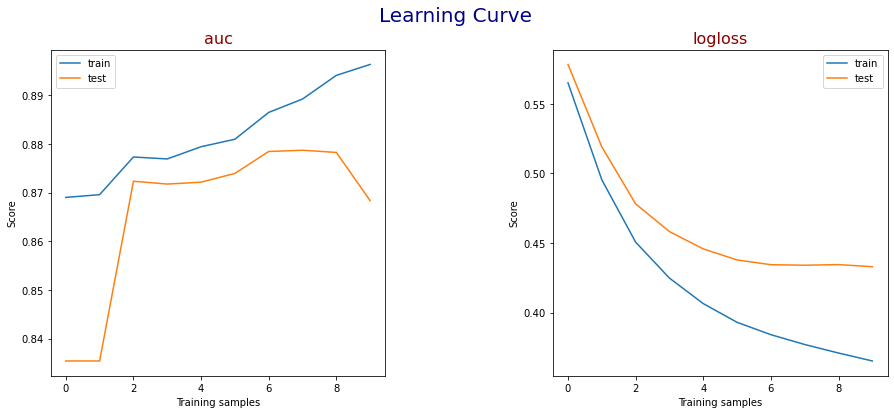

In [28]:
# retrieve performance metrics
results = xg_cl.evals_result()

# plot learning curves
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
for ax, metric in zip(axes, metrics):
    ax.plot(results['validation_0'][metric], label='train')
    ax.plot(results['validation_1'][metric], label='test')
    ax.legend()
    ax.set_title(metric, **title_param)
    ax.set_xlabel('Training samples')
    ax.set_ylabel('Score')
fig.suptitle('Learning Curve', **suptitle_param)
plt.subplots_adjust(left=None, right=None, bottom=None, top=None, hspace=None, wspace=.5);
plt.show()

### 6.2 Relations inside

Number of trees: 10


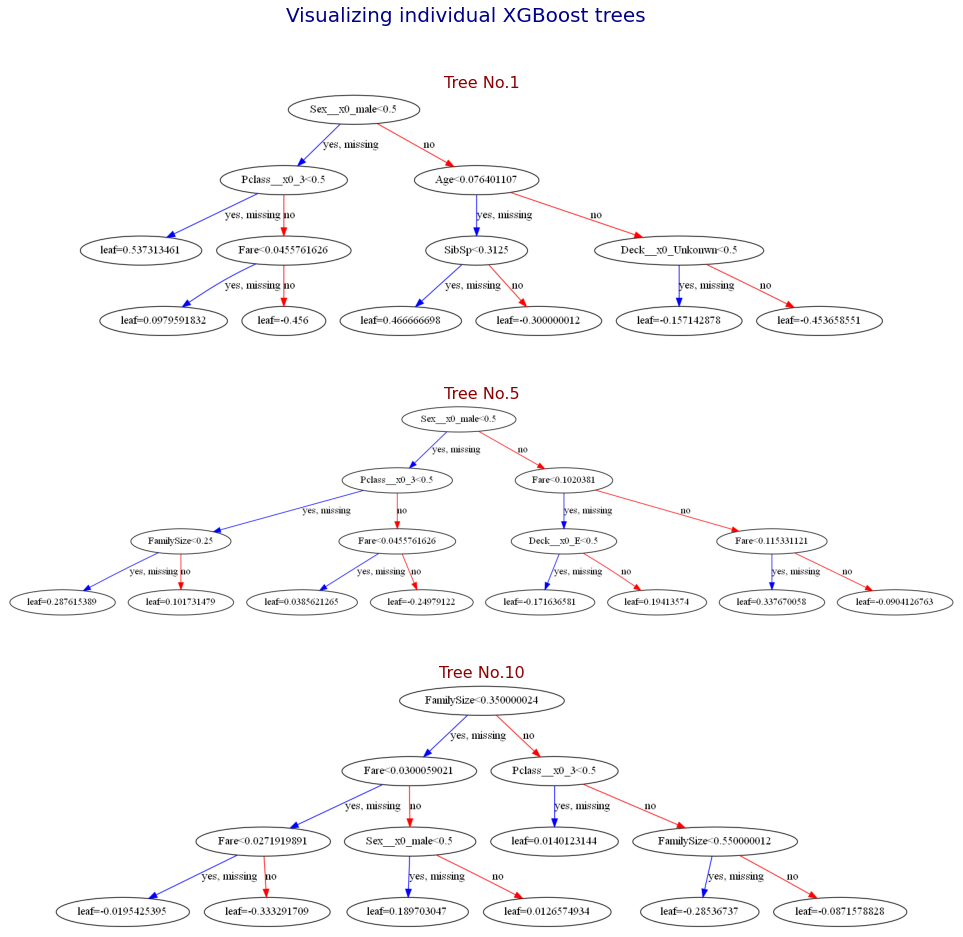

In [29]:
print('Number of trees:', xg_cl.get_num_boosting_rounds()) #also xg_cl.n_estimators

# Plot the some tree
n_tree = [0, 4, 9]
size = len(n_tree)
fig, axes = plt.subplots(size, 1, figsize=(17, 5*size))
for i in n_tree:
    ax = axes[n_tree.index(i)]
    xgb.plot_tree(xg_cl, num_trees=i, ax=ax)
    ax.set_title('Tree No.{}'.format(i+1), **title_param)
fig.suptitle('Visualizing individual XGBoost trees', **suptitle_param)
plt.subplots_adjust(left=None, right=None, bottom=None, top=.9, hspace=.2, wspace=None)
plt.show()

{'Age': 0.049534895,
 'Deck__x0_B': 0.0,
 'Deck__x0_C': 0.0037782919,
 'Deck__x0_D': 0.0,
 'Deck__x0_E': 0.037066266,
 'Deck__x0_F': 0.0,
 'Deck__x0_G': 0.0,
 'Deck__x0_T': 0.0,
 'Deck__x0_Unkonwn': 0.06992064,
 'Embarked__x0_Q': 0.0,
 'Embarked__x0_S': 0.03813818,
 'Embarked__x0_Unknown': 0.0,
 'FamilySize': 0.020239208,
 'Fare': 0.042270597,
 'Parch': 0.0,
 'Pclass__x0_2': 0.0,
 'Pclass__x0_3': 0.15447211,
 'Sex__x0_male': 0.47659668,
 'SibSp': 0.07155492,
 'Title__x0_Mr': 0.0,
 'Title__x0_Mrs': 0.03642822}
['Pclass__x0_2', 'Pclass__x0_3', 'Sex__x0_male', 'Embarked__x0_Q', 'Embarked__x0_S', 'Embarked__x0_Unknown', 'Title__x0_Mr', 'Title__x0_Mrs', 'Deck__x0_B', 'Deck__x0_C', 'Deck__x0_D', 'Deck__x0_E', 'Deck__x0_F', 'Deck__x0_G', 'Deck__x0_T', 'Deck__x0_Unkonwn', 'Age', 'SibSp', 'Parch', 'Fare', 'FamilySize']
[0.         0.15447211 0.47659668 0.         0.03813818 0.
 0.         0.03642822 0.         0.00377829 0.         0.03706627
 0.         0.         0.         0.06992064 0.04953

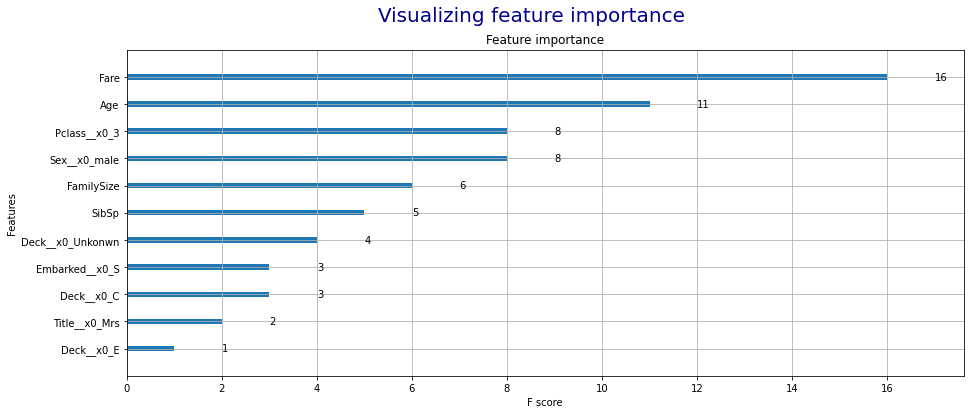

In [30]:
pprint({k:v for k,v in zip(xg_cl.get_booster().feature_names, xg_cl.feature_importances_)})
print(xg_cl.get_booster().feature_names)
print(xg_cl.feature_importances_)

# Plot the feature importances
fig, ax = plt.subplots(figsize=(15, 6))
xgb.plot_importance(xg_cl, ax=ax)
fig.suptitle('Visualizing feature importance', **suptitle_param)
#plt.subplots_adjust(left=.3, right=None, bottom=None, top=None, hspace=None, wspace=None);
plt.show()

## 6.3. Tunning this first approach

In [30]:
class XGB_Model(object):
    """
    Encapsulates the creation model, evaluation proccess and the mainly visualization process. 
    """
    METRICS = ['auc', 'logloss']
    
    def __init__(self, **kwargs):
        self.model = xgb.XGBClassifier(**kwargs)        
        
    def perform_cross_val(self, X_train, y_train, **kwargs):
        # Perform cross-validation
        cross_val_scores = cross_val_score(self.model, X_train, y_train, **kwargs)
        
        # Print avg. AUC
        print("3-fold AUC (on the training set): ", np.mean(cross_val_scores))
        
        # Fit the classifier to the training set
        self.model.fit(X_train, y_train, eval_metric=self.METRICS, eval_set=evalset, verbose=0)

        # Predict the labels of the test set: preds
        preds = self.model.predict(X_test)

        # evaluate performance - Compute the accuracy: accuracy
        score = accuracy_score(y_test, preds)
        print('3-fold AUC (on the test     set): ', score)
        

    def get_model(self):
        return self.model
    
    
    def plot_learning_curves(self):
        # retrieve performance metrics
        results = self.model.evals_result()
        
        # plot learning curves
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        for ax, metric in zip(axes, self.METRICS):
            ax.plot(results['validation_0'][metric], label='train')
            ax.plot(results['validation_1'][metric], label='test')
            ax.legend()
            ax.set_title(metric, **title_param)
            ax.set_xlabel('Training samples')
            ax.set_ylabel('Score')
        fig.suptitle('Learning Curve', **suptitle_param)
        plt.subplots_adjust(left=None, right=None, bottom=None, top=None, hspace=None, wspace=.5);
        plt.show()
        
        
    def print_num_of_trees(self):
        print('Number of trees:', self.model.get_num_boosting_rounds()) #also xg_cl.n_estimators
        
        
    def plot_relations_inside(self, trees_to_plot=[0, 4, 9]):
        self.print_num_of_trees()
        
        # Plot the some tree
        size = len(trees_to_plot)
        fig, axes = plt.subplots(size, 1, figsize=(17, 5*size))
        for i in trees_to_plot:
            ax = axes[trees_to_plot.index(i)]
            xgb.plot_tree(self.model, num_trees=i, ax=ax)
            ax.set_title('Tree No.{}'.format(i+1), **title_param)
        fig.suptitle('Visualizing individual XGBoost trees', **suptitle_param)
        plt.subplots_adjust(left=None, right=None, bottom=None, top=.9, hspace=.2, wspace=None)
        plt.show()
        
    
    def plot_feature_importance(self):
        # Plot the feature importances
        fig, ax = plt.subplots(figsize=(15, 6))
        xgb.plot_importance(self.model, ax=ax)
        fig.suptitle('Visualizing feature importance', **suptitle_param)
        #plt.subplots_adjust(left=.3, right=None, bottom=None, top=None, hspace=None, wspace=None);
        plt.show()
    
    def tunning_model(self, gbm_param_grid, X, y, scoring='roc_auc'):
        grid_mse = GridSearchCV(estimator=self.model, param_grid=gbm_param_grid, scoring=scoring, cv=4, verbose=0)
        grid_mse.fit(X, y)
        print("Best parameters found: ", grid_mse.best_params_)
        print("Best {} found: ".format(scoring), grid_mse.best_score_)
        return grid_mse.best_params_
    
    def get_feature_importances(self):
        pprint({k:v for k,v in zip(self.model.get_booster().feature_names, self.model.feature_importances_)})

In [31]:
df_data.columns

Index(['Pclass__x0_2', 'Pclass__x0_3', 'Sex__x0_male', 'Embarked__x0_Q',
       'Embarked__x0_S', 'Embarked__x0_Unknown', 'Title__x0_Mr',
       'Title__x0_Mrs', 'Deck__x0_B', 'Deck__x0_C', 'Deck__x0_D', 'Deck__x0_E',
       'Deck__x0_F', 'Deck__x0_G', 'Deck__x0_T', 'Deck__x0_Unkonwn',
       'Survived', 'Age', 'SibSp', 'Parch', 'Fare', 'FamilySize'],
      dtype='object')

3-fold AUC (on the training set):  0.8572014430160498
3-fold AUC (on the test     set):  0.8044692737430168
{'Age': 0.086131826,
 'Deck__x0_B': 0.0,
 'Deck__x0_C': 0.0,
 'Deck__x0_D': 0.0,
 'Deck__x0_E': 0.0,
 'Deck__x0_F': 0.0,
 'Deck__x0_G': 0.0,
 'Deck__x0_T': 0.0,
 'Deck__x0_Unkonwn': 0.09799235,
 'Embarked__x0_Q': 0.0,
 'Embarked__x0_S': 0.033570837,
 'Embarked__x0_Unknown': 0.0,
 'FamilySize': 0.057224195,
 'Fare': 0.06122727,
 'Parch': 0.0,
 'Pclass__x0_2': 0.0,
 'Pclass__x0_3': 0.14084291,
 'Sex__x0_male': 0.47987625,
 'SibSp': 0.0,
 'Title__x0_Mr': 0.0,
 'Title__x0_Mrs': 0.043134294}


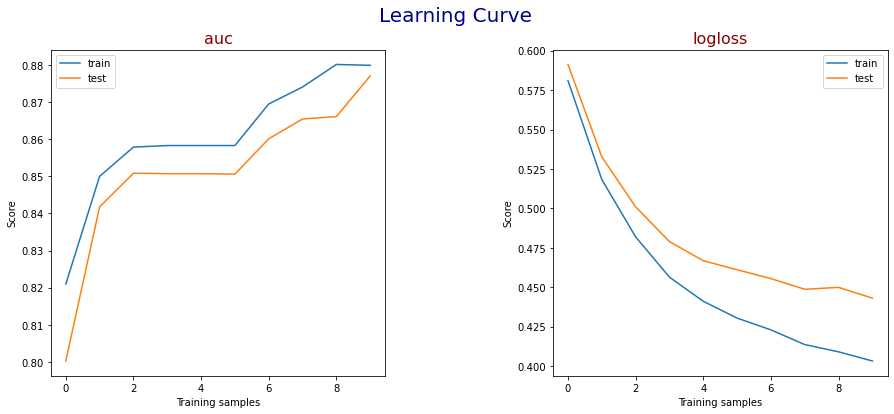

In [32]:
# Create arrays for the features and the target: X, y
X, y = df_data.drop('Survived', axis=1), df_data.Survived
#X = df_data[['Fare', 'Age', 'Pclass__x0_3', 'Sex__x0_male', 'FamilySize', 'SibSp', 'Deck__x0_Unkonwn', 'Embarked__x0_S', 
#             'Deck__x0_C', 'Title__x0_Mrs', 'Deck__x0_E']]
#y = df_data.Survived
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

# define the datasets to evaluate each iteration
evalset = [(X_train, y_train), (X_test,y_test)]

xgb_model = XGB_Model(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, seed=SEED, 
                      n_estimators=10, max_depth=2) 
xgb_model.perform_cross_val(X_train, y_train, cv=3, scoring='roc_auc')
xgb_model.get_feature_importances()
xgb_model.plot_learning_curves()

3-fold AUC (on the training set):  0.8575304236821091
3-fold AUC (on the test     set):  0.8044692737430168
{'Age': 0.08613183,
 'Deck__x0_C': 0.0,
 'Deck__x0_E': 0.0,
 'Deck__x0_Unkonwn': 0.09799237,
 'Embarked__x0_S': 0.03357084,
 'FamilySize': 0.057224203,
 'Fare': 0.061227277,
 'Pclass__x0_3': 0.14084293,
 'Sex__x0_male': 0.4798763,
 'SibSp': 0.0,
 'Title__x0_Mrs': 0.0431343}


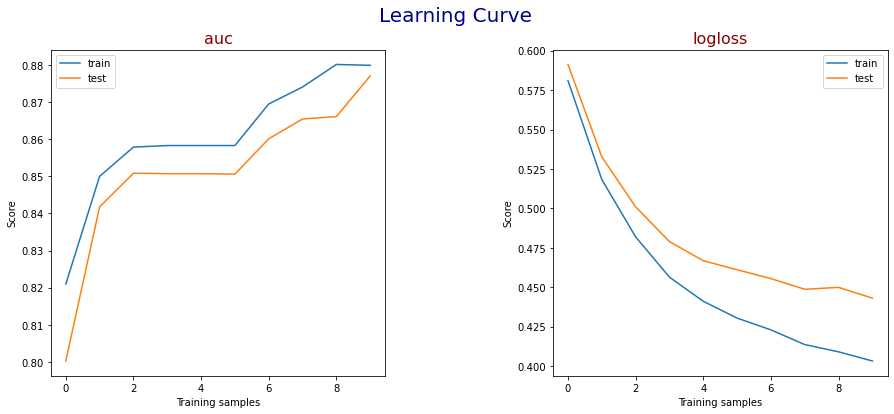

In [39]:
# Create arrays for the features and the target: X, y
X, y = df_data.drop('Survived', axis=1), df_data.Survived
#X = df_data[['Fare', 'Age', 'Pclass__x0_3', 'Sex__x0_male', 'FamilySize', 'SibSp', 'Deck__x0_Unkonwn', 'Embarked__x0_S', 
#             'Deck__x0_C', 'Title__x0_Mrs', 'Deck__x0_E']]
#y = df_data.Survived
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

# define the datasets to evaluate each iteration
evalset = [(X_train, y_train), (X_test,y_test)]

xgb_model = XGB_Model(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, seed=SEED, 
                      n_estimators=10, max_depth=2) 
xgb_model.perform_cross_val(X_train, y_train, cv=3, scoring='roc_auc')
xgb_model.get_feature_importances()
xgb_model.plot_learning_curves()

In [35]:
# Create arrays for the features and the target: X, y
X, y = df_data.drop('Survived', axis=1), df_data.Survived
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

evalset = [(X_train, y_train), (X_test,y_test)]

gbm_param_grid = {'learning_rate': [0.01, 0.1, 0.5, 0.9, 1],
                  'n_estimators' : [10, 50, 100, 200, 500],
                  'max_depth'    : [3, 5, 10]}

xgb_model = XGB_Model(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, 
                      n_estimators=10, max_depth=2, seed=SEED) 
xgb_model.tunning_model(gbm_param_grid, X_train, y_train)

Best parameters found:  {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}
Best roc_auc found:  0.8708148446954418


{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}

3-fold AUC (on the training set):  0.8662327242105172
3-fold AUC (on the test     set):  0.8100558659217877


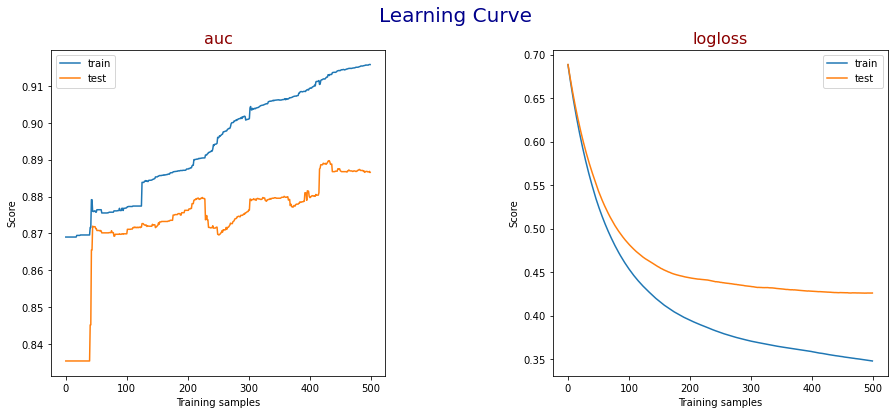

In [36]:
xgb_model = XGB_Model(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, seed=SEED, 
                      n_estimators=500, max_depth=3, learning_rate=0.01) 
xgb_model.perform_cross_val(X_train, y_train, cv=5, scoring='roc_auc')
xgb_model.plot_learning_curves()

# Documentation:
- Titanic - Machine Learning from Disaster: https://www.kaggle.com/c/titanic/overview
- Basic Feature Engineering with the Titanic Data: https://triangleinequality.wordpress.com/2013/09/08/basic-feature-engineering-with-the-titanic-data/
- Titanic tutorial: https://www.kaggle.com/alexisbcook/titanic-tutorial
- When to NOT use XGBoost?: https://www.kaggle.com/discussion/196542
- pandas fill null values by the mean of that category: https://stackoverflow.com/questions/62736410/pandas-fill-null-values-by-the-mean-of-that-category
- pandas.core.groupby.DataFrameGroupBy.transform: https://pandas.pydata.org/docs/reference/api/pandas.core.groupby.DataFrameGroupBy.transform.html
- Tunning XGBoost: https://machinelearningmastery.com/tune-xgboost-performance-with-learning-curves/

In [31]:
# Working with substring
str = "Messi is the best soccer player"
print("soccer" in str)

fullstring = "Messi is the best bkb player"
substring = "SOCCER|BKB"

m = search(substring, fullstring.upper())
if m:
    print(fullstring.upper()[m.start():m.end()])
#dir(result)

True
BKB


In [32]:
# Finding the title
title_list = ['Mrs', 'Mr', 'Master', 'Miss', 'Major', 'Rev', 'Dr', 'Ms', 'Mlle', 'Col', 'Capt', 'Mme', 'Countess',
              'Don', 'Jonkheer']
title_to_find = '|'.join(title_list)

def finding_title(name, title_to_find=title_to_find):
    m = search(title_to_find, name)
    if m:
        return name[m.start():m.end()]
    return 'No title'

#df['Title'] = df['Name'].apply(lambda n: finding_title(n))
#df.groupby('Title').Title.count()